# Analysing the results of 3D glacier surface velocities

## Objective

* Analyse the spatial variations in velocities for one or more glaciers in Mt. Baker.
* Analyse the temporal variations in velocities for one or more glaciers in Mt. Baker.


### Imports and filenames

In [1]:
import numpy as np
import xarray as xr
import shapely
import xdem
import easysnowdata
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import contextily as ctx
from glob import glob
from scipy.linalg import lstsq
from datetime import datetime

import matplotlib.pyplot as plt

/Users/ayushg/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
velocity_file = '../offsets/3d_vel_2021.nc'
glims_file = '../shapefiles/glims_polygons.shp'

### Reading datasets required for analysis

In [3]:
# Loading the 3D velocity data
vel3d = xr.open_dataset(velocity_file)
vel3d.rio.write_crs("EPSG:32610", inplace=True)

<xarray.Dataset> Size: 634MB
Dimensions:      (time: 28, y: 1015, x: 929)
Coordinates:
  * time         (time) datetime64[ns] 224B 2021-01-12 2021-01-24 ... 2021-12-14
  * y            (y) float64 8kB 5.408e+06 5.408e+06 ... 5.398e+06 5.398e+06
  * x            (x) float64 7kB 5.819e+05 5.819e+05 ... 5.912e+05 5.912e+05
    spatial_ref  int64 8B 0
Data variables:
    velocity_SN  (time, y, x) float64 211MB ...
    velocity_WE  (time, y, x) float64 211MB ...
    velocity_V   (time, y, x) float64 211MB ...

#### Reading GLIMS - Randolph Glacier Inventory data

The Randolph Glacier Inventory ([RGI](https://www.glims.org/RGI/)) is a globally complete inventory of glacier outlines. It is a subset of the database compiled by the Global Land Ice Measurements from Space (GLIMS) initiative. 

We read the shapefile for entire data and crop it Mt. Baker region, and filter the dataframe to get the 15 largest glaciers in Mt. Baker.


In [4]:
glims_gdf = gpd.read_file(glims_file)
aoi = np.array([-121.96, 48.713,-121.6869, 48.713,-121.6869, 48.8539,-121.96, 48.8539,-121.96, 48.713])
lats, lons = aoi[::2], aoi[1::2]
bounds = np.array([lats.min(), lons.min(), lats.max(), lons.max()])
glims_gdf_aoi = glims_gdf.clip(bounds)
glims_gdf_aoi = glims_gdf_aoi.to_crs(vel3d.rio.crs)
glims_gdf_aoi['anlys_time'] = glims_gdf_aoi['anlys_time'].apply(pd.to_datetime)
glims_gdf_aoi = glims_gdf_aoi[glims_gdf_aoi['anlys_time'].dt.year > 2015]

# Filtering the 15 largest glaciers
glims_gdf_aoi['area'] = glims_gdf_aoi.area
glims_gdf_aoi.sort_values('area', ascending=False, inplace=True)
glims_gdf_aoi = glims_gdf_aoi.iloc[:7]

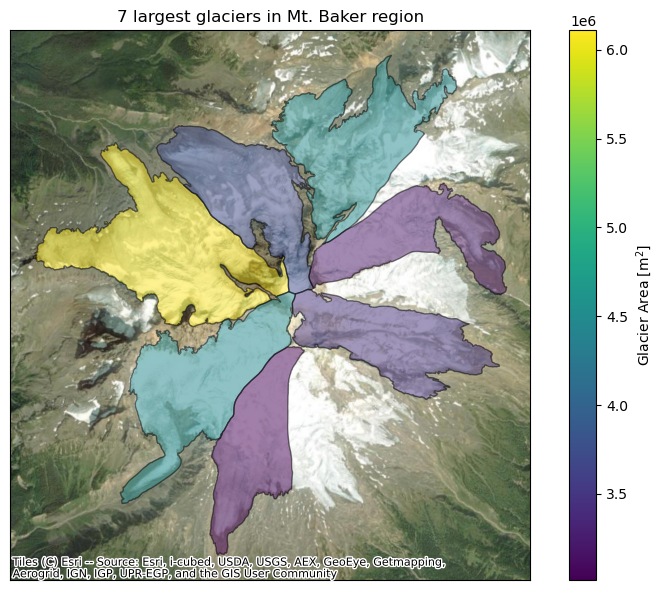

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# glims_gdf_aoi.plot(ax=ax, edgecolor='black', facecolor='none')
glims_gdf_aoi.plot('area', ax=ax, edgecolor='black', alpha=0.5, legend=True, 
                   legend_kwds={'label': "Glacier Area [m$^2$]"})
ctx.add_basemap(ax, crs=glims_gdf_aoi.crs, source=ctx.providers.Esri.WorldImagery)
ax.set(xticks=[], yticks=[])
ax.set_title('7 largest glaciers in Mt. Baker region')

plt.tight_layout()
plt.savefig('../docs/figures/7_largest_glaciers.png', dpi=300, bbox_inches='tight', transparent=True)

#### Getting Copernicus DEM for Mt. Baker

Using easysnowdata python library to get cop30 data and then using xDEM for getting its hillshade.

In [6]:
baker_dem = easysnowdata.topography.get_copernicus_dem(glims_gdf_aoi.to_crs('EPSG:4326')).rio.reproject_match(vel3d)
baker_dem.rio.to_raster('../data/cop30_baker.tif')

In [150]:
!gdaldem hillshade ../data/cop30_baker.tif ../data/cop30_baker_hs.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
baker_dem_hs = rxr.open_rasterio('../data/cop30_baker_hs.tif').squeeze()

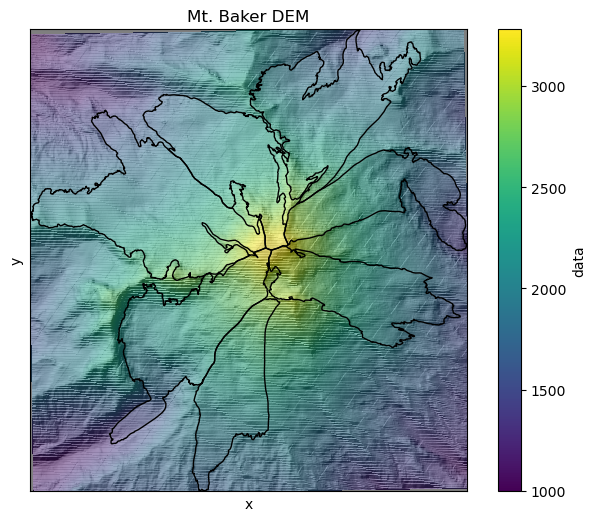

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


baker_dem.plot(ax=ax, cmap='viridis', add_colorbar=True)
baker_dem_hs.plot(ax=ax, vmin=0, vmax=255, cmap='gray', add_colorbar=False, alpha=0.5)

glims_gdf_aoi.plot(ax=ax, edgecolor='black', facecolor='none')
ax.set_title('Mt. Baker DEM')
ax.set(xlim=glims_gdf_aoi.total_bounds[::2], ylim=glims_gdf_aoi.total_bounds[1::2],
       xticks=[], yticks=[])
ax.set_aspect('equal')

plt.savefig('../docs/figures/elevation.png', dpi=300, bbox_inches='tight', transparent=True)

/var/folders/q7/4r0lxc6j59lf_bjt9p2p0y8h0000gp/T/ipykernel_71027/3133630755.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(p.axes.flat):


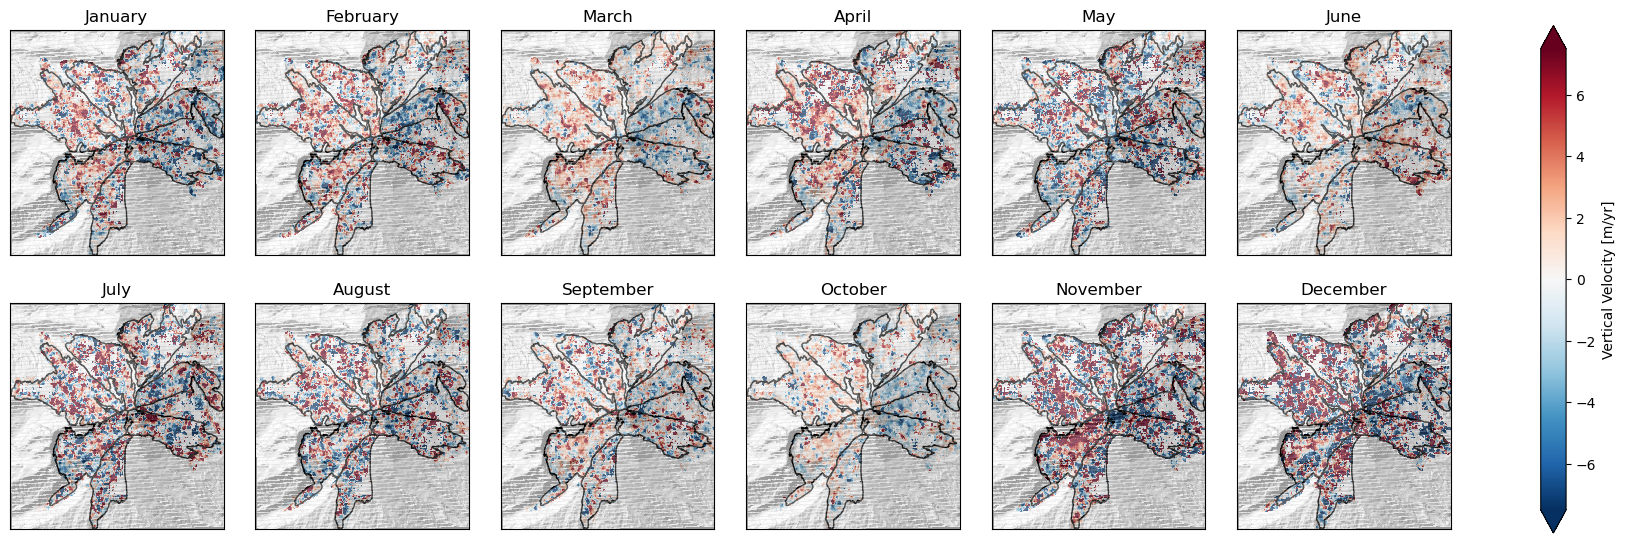

In [18]:
# fig, ax = plt.subplots(3, 4, figsize=(8, 6))
p = vel3d['velocity_V'].groupby('time.month').mean().plot.imshow(col='month', col_wrap=6, vmin=-7.5,
                                                                  cbar_kwargs={'label': 'Vertical Velocity [m/yr]'},)
for i, ax in enumerate(p.axes.flat):
   #  ax.set_aspect('equal')
    glims_gdf_aoi.to_crs(vel3d.rio.crs).plot(ax=ax, facecolor='none', edgecolor='black')
    # ax.imshow(baker_dem_hs.data, cmap='gray', alpha=0.5)
    baker_dem_hs.plot(ax=ax, vmin=0, vmax=255, cmap='gray', alpha=0.4, add_colorbar=False)
    # ax.axis('off')
    ax.set(xlim=glims_gdf_aoi.total_bounds[::2], ylim=glims_gdf_aoi.total_bounds[1::2],
       xticks=[], yticks=[], xlabel='', ylabel='')
    
    ax.set_title(datetime(2000, i+1, 1).strftime('%B'))

# plt.suptitle('Vertical Velocities of glaciers in Mt. Baker region - 2021')
plt.savefig('../docs/figures/vert_velocity.png', dpi=300, bbox_inches='tight', transparent=False)

/var/folders/q7/4r0lxc6j59lf_bjt9p2p0y8h0000gp/T/ipykernel_71027/3670519349.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(p.axes.flat):


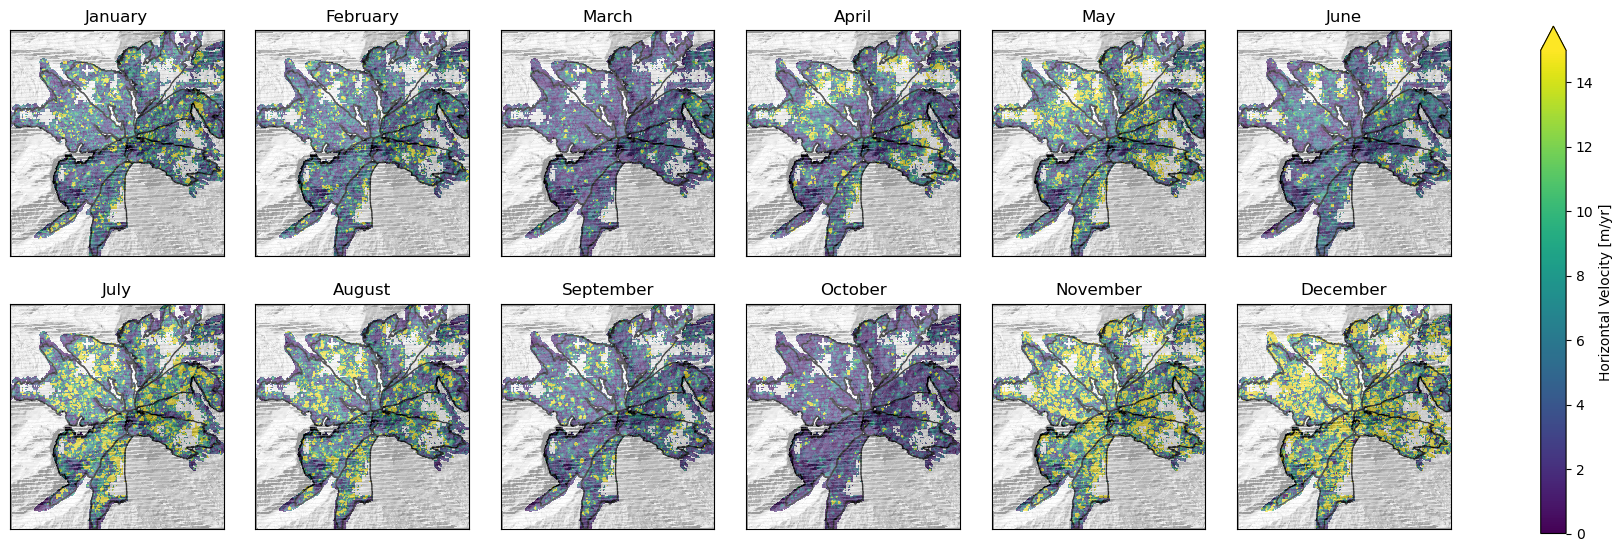

In [17]:
v_monthly_mean = vel3d.groupby('time.month').mean()
v_hor = xr.ufuncs.sqrt(v_monthly_mean['velocity_SN']**2 + v_monthly_mean['velocity_WE']**2)
p = v_hor.plot.imshow(col='month', col_wrap=6, vmax=15, cbar_kwargs={'label': 'Horizontal Velocity [m/yr]'},)
for i, ax in enumerate(p.axes.flat):
    glims_gdf_aoi.to_crs(vel3d.rio.crs).plot(ax=ax, facecolor='none', edgecolor='black')
    baker_dem_hs.plot(ax=ax, vmin=0, vmax=255, cmap='gray', alpha=0.4, add_colorbar=False)
    ax.set(xlim=glims_gdf_aoi.total_bounds[::2], ylim=glims_gdf_aoi.total_bounds[1::2],
       xticks=[], yticks=[], xlabel='', ylabel='')
    
    ax.set_title(datetime(2000, i+1, 1).strftime('%B'))

# plt.suptitle('Vertical Velocities of glaciers in Mt. Baker region - 2021')
plt.savefig('../docs/figures/hor_velocity.png', dpi=300, bbox_inches='tight', transparent=False)

### Spatial variation of velocities with terrain

Using PyGMT library to plot the 3D visualisation of flow direction and velocity variation with terrain.

In [31]:
import pygmt

def angle_compute(vx, vy):
    if vx<0:
        ang = 180 + (np.arctan(vy/vx)*180/np.pi)
    elif vx>=0:
        ang = np.arctan(vy/vx)*180/np.pi
    # else:
    #     ang = 90
    return ang

def get_velocity_vectors(vel, easton_dem, spacing=13, buffer=2):
    '''
    Function to extract velocity vectors from the 3D velocity data giving the position, velocity and angle of the vector
    '''
    xlen = vel.rio.width
    ylen = vel.rio.height

    lats = vel.y.values
    lons = vel.x.values

    posp = []
    velp = []
    vectorsp = []

    xvals = np.arange(buffer, xlen, spacing)
    yvals = np.arange(buffer, ylen, spacing)

    for xval in xvals:
        for yval in yvals:

            lon = lons[xval]
            lat = lats[yval]
            vx = vel['velocity_WE'].isel(x=slice(xval-buffer, xval+buffer), y=slice(yval-buffer, yval+buffer)).mean().values
            vy = vel['velocity_SN'].isel(x=slice(xval-buffer, xval+buffer), y=slice(yval-buffer, yval+buffer)).mean().values
            z = np.median(easton_dem.isel(x=slice(xval-buffer, xval+buffer), y=slice(yval-buffer, yval+buffer)).values)
            vt = np.sqrt(vx**2 + vy**2)

            # if vt>1:
            if np.isnan([vx, vy, vt]).any():
                continue
        
            posp.append([lon, lat, z]) # x, y, z
            # print(vx, vy)
            angl = angle_compute(-vx, vy)
            velp.append([angl, vt])
            vectorsp.append([lon, lat, angl, vt])

    velp = np.array(velp)
    posp = np.array(posp)[velp[:, 1]<100]
    vectorsp = np.array(vectorsp)[velp[:, 1]<100]
    
    return posp, velp, vectorsp

In [ ]:
baker_dsm_3dem = rxr.open_rasterio('/Users/ayushg/Desktop/STV_Research/DeepDEM/data_kartik2/10252024/processed_rasters_v2/final_lidar_data.tif').squeeze()
new_width = int(baker_dsm_3dem.rio.width * (1/10))
new_height = int(baker_dsm_3dem.rio.height * (1/10))
baker_dsm_3dem = baker_dsm_3dem.rio.reproject(baker_dsm_3dem.rio.crs, shape=(new_height, new_width))

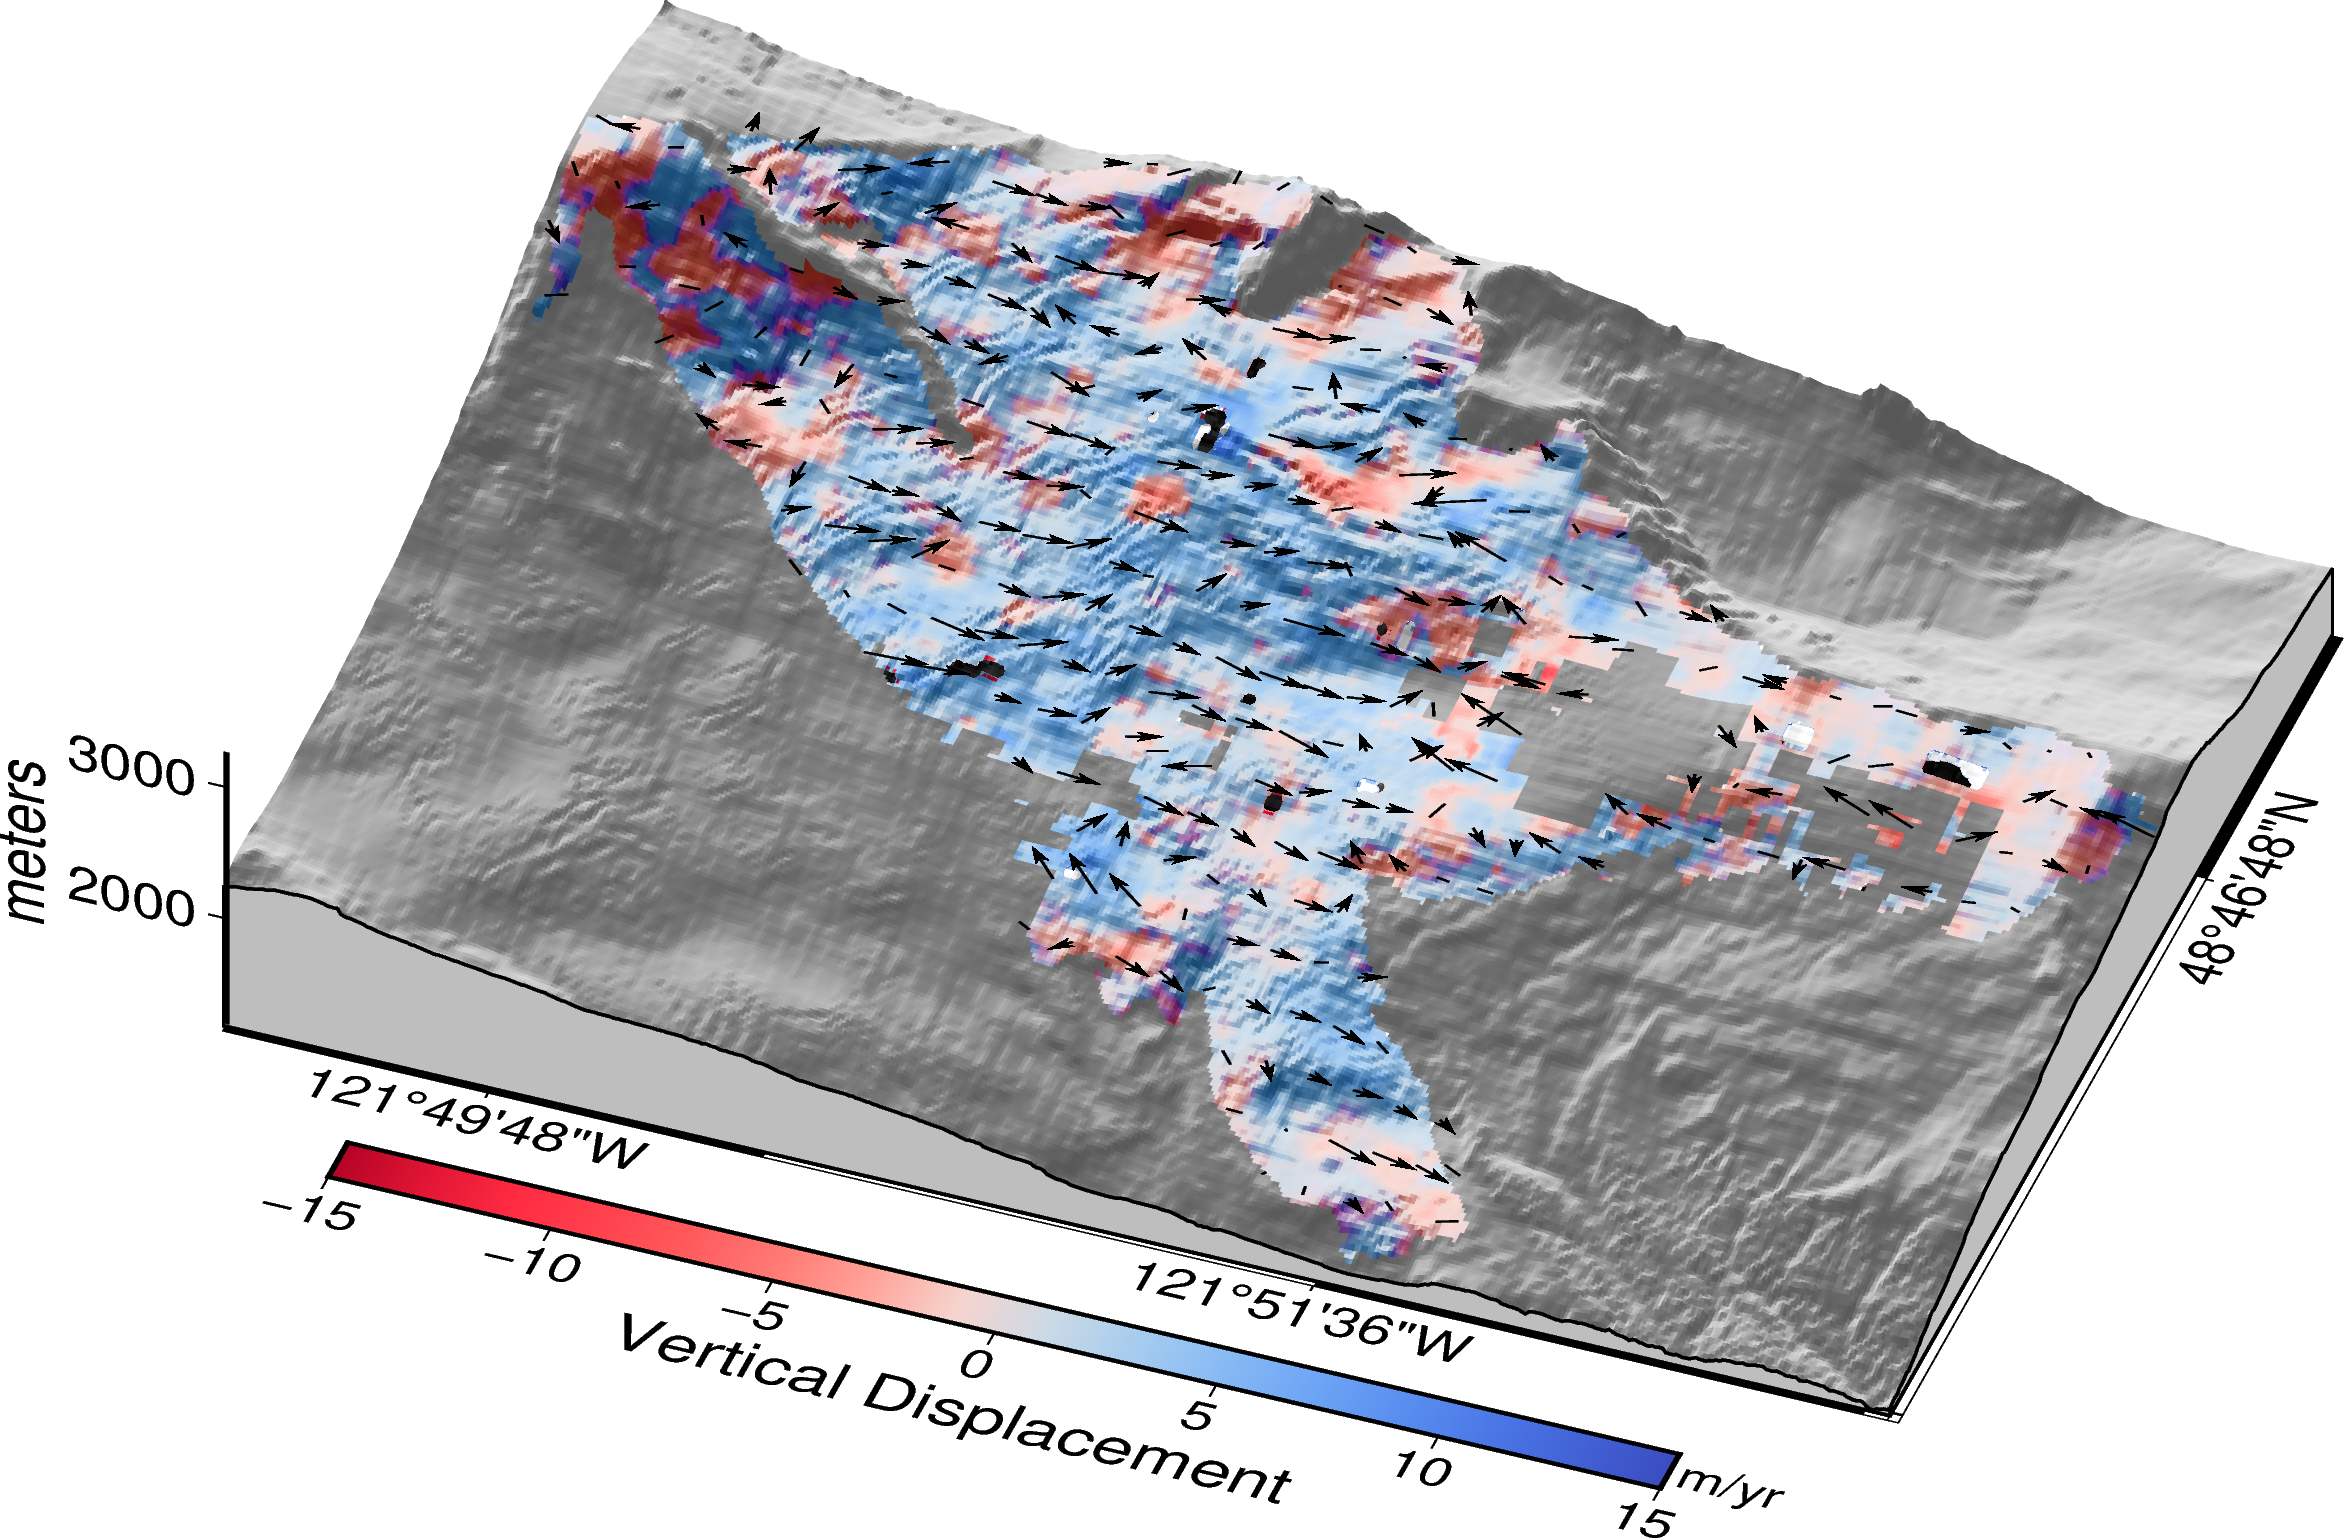

In [208]:
fig = pygmt.Figure()

# Getting the bounds of the glaciers in WGS84 projection
bound_rg = glims_gdf_aoi.to_crs(4326).iloc[0].geometry.bounds
reg = [np.round(bound_rg[0], 5), bound_rg[2], bound_rg[1], bound_rg[3]]

# Reprojecting the DEM and velocity data to WGS84 onto the same grid
easton_dem = baker_dsm_3dem.rio.reproject('EPSG:4326')
vel = vel3d.groupby('time.month').mean().sel(month=range(2, 11)).mean(dim='month').rio.clip([glims_gdf_aoi.iloc[0].geometry]).rio.reproject(4326)
easton_dem = easton_dem.rio.reproject_match(vel)

# Defining the frame for the plot
frame =  ["xa0.03f0.02","ya0.03f0.02", "z1000+lmeters", "wNWnZ"]

# Defining the color palette for the plot
topo_cpt = pygmt.makecpt(cmap='/Users/ayushg/Desktop/IITK Data/cool-warm.cpt',series=f'-15/15/2',continuous=True, no_bg=True, reverse=True)

shade = '+a145+ne0.8+m0'
min = 1200
easton_dem = xr.where(easton_dem < min, min, easton_dem.values)

# Plotting the velocity raster on the DEM surface
with pygmt.config(FONT_LABEL="17p,black",
                  FONT_ANNOT_SECONDARY="12p",
                 FONT_ANNOT_PRIMARY="15p,black",
                 MAP_ANNOT_OBLIQUE="lat_parallel"
                 ):
    
    fig.grdview(grid=easton_dem,
                region=reg,
                frame=frame,
                perspective=[-20,40], # Gl3
                projection='M15c',
                zsize='3c',
                surftype='s',
                cmap=topo_cpt,
                plane=f"{min}+ggrey",
                shading=shade,
                drapegrid=vel['velocity_V'],
                contourpen=None,
               )

with pygmt.config(
            FONT_ANNOT_SECONDARY="15p",
            FONT_ANNOT_PRIMARY="16p,black",
            FONT_LABEL="20p,black"
        ):
    fig.colorbar(perspective=[160,40], position='jBL+o1.5c/-1.6c+h', frame=["a5", "x+lVertical Displacement", "y+lm/yr"])

# Plotting the flow directions
posp, velp, vectorsp = get_velocity_vectors(vel, easton_dem, spacing=13)
with pygmt.config(FONT_LABEL="12p,black",
                 FONT_ANNOT_PRIMARY="12p,black"):
    dir = vectorsp[:, 2:].T
    dir2 = dir.copy()
    dir2[1] = np.log10(dir[1]+1)*(1/1.5)
    
    style = "v0.22c+ea+a30"
    region2 = [*reg, min, float(easton_dem.max().values)]
    fig.plot3d(x=posp[:,0], y=posp[:,1], z=posp[:,2],  projection='M15c', zsize=zsize,
               perspective=[-20, 40],
               style=style, direction=dir2, pen='0.65p', fill="black",
              region=region2)
    
    
fig.show(width=2000)
fig.savefig("D_vert.png", dpi=300, resize="+m0.5/0.7")

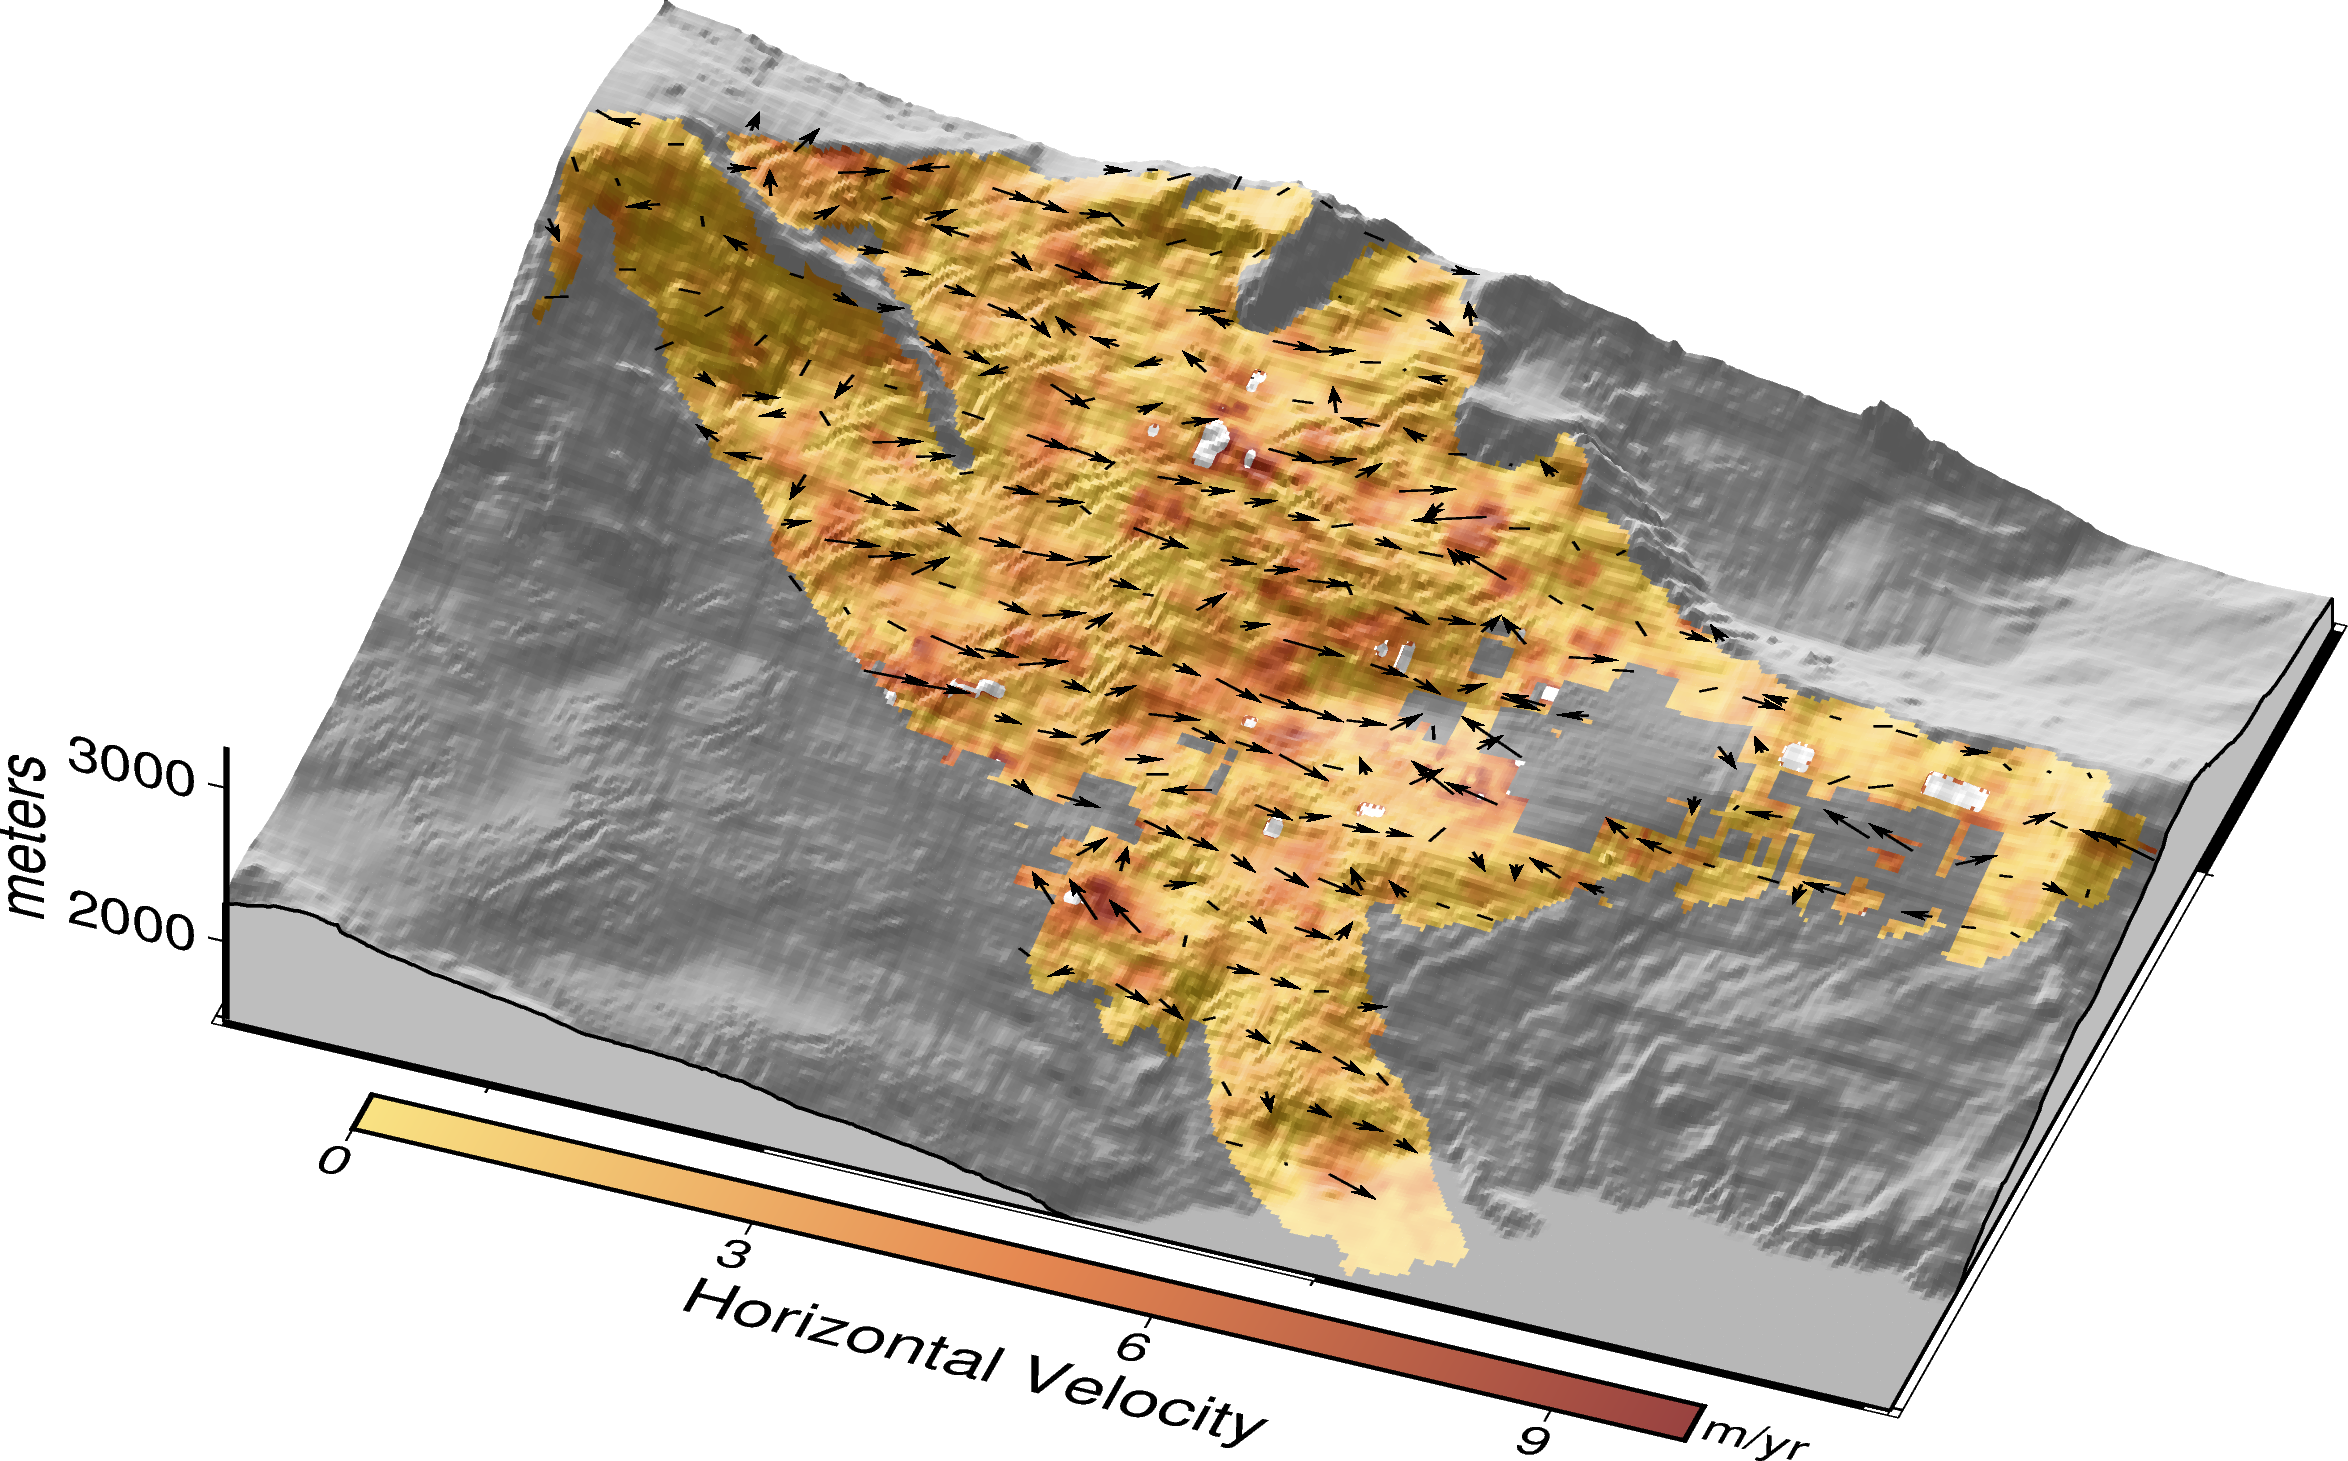

In [ ]:
fig = pygmt.Figure()

# Getting the bounds of the glaciers in WGS84 projection
bound_rg = glims_gdf_aoi.to_crs(4326).iloc[0].geometry.bounds
reg = [bound_rg[0], bound_rg[2], bound_rg[1], bound_rg[3]]

# Reprojecting the DEM and velocity data to WGS84 onto the same grid
easton_dem = baker_dsm_3dem.rio.reproject('EPSG:4326')
vel = vel3d.groupby('time.month').mean().sel(month=range(2, 11)).mean(dim='month').rio.clip([glims_gdf_aoi.iloc[0].geometry]).rio.reproject(4326)
easton_dem = easton_dem.rio.reproject_match(vel)

# Defining the frame for the plot
frame =  ["xa0.03f0.02","ya0.03f0.02", "z1000+lmeters", "wSEnZ"]

# Defining the color palette for the plot
topo_cpt = pygmt.makecpt(cmap='lajolla', background='gray',series="0/10/5",continuous=True, truncate=[0.35, 0.9], no_bg=True, reverse=True)

shade = '+a145+ne0.8+m0'
min = 1500
easton_dem = xr.where(easton_dem < min, min, easton_dem.values)

# Plotting the velocity raster on the DEM surface
with pygmt.config(FONT_LABEL="17p,black",
                  FONT_ANNOT_SECONDARY="12p",
                 FONT_ANNOT_PRIMARY="15p,black",
                 MAP_ANNOT_OBLIQUE="lat_parallel"
                 ):
    
    fig.grdview(grid=easton_dem,
                region=reg,
                frame=frame,
                perspective=[-20,40],
                projection='M15c',
                zsize='3c',
                surftype='s',
                cmap=topo_cpt,
                plane=f"{min}+ggrey",
                shading=shade,
                # Drapegrid is the horizontal velocity being plotted on the surface
                drapegrid=xr.ufuncs.sqrt(vel['velocity_SN']**2 + vel['velocity_WE']**2),
                contourpen=None,
               )

# Plotting the flow directions
posp, velp, vectorsp = get_velocity_vectors(vel, easton_dem, spacing=13)
with pygmt.config(
            FONT_ANNOT_SECONDARY="15p",
            FONT_ANNOT_PRIMARY="16p,black",
            FONT_LABEL="20p,black"
        ):
    fig.colorbar(perspective=[160,40], position='jBL+o1.5c/-1c+h', frame=["a3", "x+lHorizontal Velocity", "y+lm/yr"])

with pygmt.config(FONT_LABEL="12p,black",
                 FONT_ANNOT_PRIMARY="12p,black"):
    dir = vectorsp[:, 2:].T
    dir2 = dir.copy()
    dir2[1] = np.log10(dir[1]+1)*(1/1.5)
                       # 1.5
    
    style = "v0.22c+ea+a30"
    region2 = [*reg, min, float(easton_dem.max().values)]
    fig.plot3d(x=posp[:,0], y=posp[:,1], z=posp[:,2],  projection='M15c', zsize=zsize,
               perspective=[-20, 40],
               style=style, direction=dir2, pen='0.65p', fill="black",
              region=region2)
    
    
fig.show(width=2000)
fig.savefig("../docs/figures/D_hor.png", dpi=300, resize="+m0.5/0.7")

## Conclusions

* Velocities for november, december and january have a lot of noise, which might be due to dense snow cover on Mt. Baker.

* Vertical velocities are higher in steep regions.

* We observe some increase in vertical velocities during April, May, July and August, which might be during to melting happening during those months.